<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Comparison of 3 Medium Size French cities profiles</font></h1>

## Introduction

As we did with New York and Toronto, my idea is to perform data exploration of a set of French midsize cities and to determine whether the resulting segmentation and clustering reflects some similarities or specificities
Data exploration will be performed for the cities of Toulouse, Bordeaux and Nantes. Apart from the size criteria, selection of those cities is also correlated to the availability of proper location datasets on open platforms 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [66]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [67]:
!pip install wget
import wget

<a id='item1'></a>

# 1. Download and Explore Dataset

## 1.1. Toulouse

Location of data of the neighborhoods of the city of Toulouse are freely accessible on an open data portal managed by the Metropolitan area of Toulouse https://data.toulouse-metropole.fr

In [5]:
## Getting access to Toulouse neighborhoods dataset
print('Toulouse --> Beginning file download with wget module')

url = 'https://data.toulouse-metropole.fr/explore/dataset/quartiers-de-democratie-locale0/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true'
## Saving data to a csv file
wget.download(url, 'toulouse_data.csv')

Toulouse --> Beginning file download with wget module


'toulouse_data.csv'

In [11]:
## Loading data into a Pandas DF
toulouse_data = pd.read_csv('toulouse_data.csv', sep=';')

In [8]:
## Checking format of the collected data
toulouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Geo Point            20 non-null object
Geo Shape            20 non-null object
Quartier             20 non-null float64
Nom_Quartier         20 non-null object
Maire_de_quartier    20 non-null object
Secteur              20 non-null int64
Nom_Secteur          20 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 1.2+ KB


OK we have 20 Neighborhoods !

In [9]:
## Checking head of the collected data
toulouse_data.head()

,Geo Point,Geo Shape,Quartier,Nom_Quartier,Maire_de_quartier,Secteur,Nom_Secteur
0,"43.6268662461,1.43092241379","{""type"": ""Polygon"", ""coordinates"": [[[1.423811...",3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Maxime Boyer,3,Toulouse Nord
1,"43.5710386646,1.40036865615","{""type"": ""Polygon"", ""coordinates"": [[[1.395304...",6.3,Mirail / Reynerie / Bellefontaine,Franck Biasotto,6,Toulouse Ouest
2,"43.583780781,1.44334028476","{""type"": ""Polygon"", ""coordinates"": [[[1.427984...",5.3,Saint-Michel / Le Busca / Empalot / Saint-Agne,Françoise Ampoulange,5,Toulouse Sud Est
3,"43.5561377053,1.40288483621","{""type"": ""Polygon"", ""coordinates"": [[[1.438801...",6.4,Saint-Simon / Lafourguette / Oncopole,Romuald Pagnucco,6,Toulouse Ouest
4,"43.5736621575,1.48969070563","{""type"": ""Polygon"", ""coordinates"": [[[1.495310...",5.1,Pont des Demoiselles / Ormeau/ Montaudran / La...,Emillion Esnault,5,Toulouse Sud Est


It appears that some information of the data frame is useless : Geo Shape, Quartier, Maire_de_quartier.
Lets suppress those columns
latitude & longitude information are stored in a single column. Lets split them in dedicated "latitue" and "longitude" columns and convert them to float

In [12]:
### Dropping columns with unrelevant data for the project
toulouse_data.drop(columns =["Geo Shape","Quartier", "Maire_de_quartier"], inplace = True)
### Spliting Geometry X Y columns
toulouse_data['Latitude'] = toulouse_data["Geo Point"].str.split(",", n = 1, expand = True)[0].astype(float) 
toulouse_data['Longitude'] = toulouse_data["Geo Point"].str.split(",", n = 1, expand = True)[1].astype(float)
toulouse_data.drop(columns =["Geo Point"], inplace = True)
### Checking result
toulouse_data.head()

,Nom_Quartier,Secteur,Nom_Secteur,Latitude,Longitude
0,Minimes / Barrière de Paris / Ponts-Jumeaux,3,Toulouse Nord,43.626866,1.430922
1,Mirail / Reynerie / Bellefontaine,6,Toulouse Ouest,43.571039,1.400369
2,Saint-Michel / Le Busca / Empalot / Saint-Agne,5,Toulouse Sud Est,43.583781,1.443340
3,Saint-Simon / Lafourguette / Oncopole,6,Toulouse Ouest,43.556138,1.402885
4,Pont des Demoiselles / Ormeau/ Montaudran / La...,5,Toulouse Sud Est,43.573662,1.489691


Renaming data frame columns to get consistent names between each cities

In [15]:
toulouse_data=toulouse_data.rename(columns={"Nom_Secteur": "Borough", "Nom_Quartier": "Neighborhood"})
toulouse_data.head()

,Neighborhood,Secteur,Borough,Latitude,Longitude
0,Minimes / Barrière de Paris / Ponts-Jumeaux,3,Toulouse Nord,43.626866,1.430922
1,Mirail / Reynerie / Bellefontaine,6,Toulouse Ouest,43.571039,1.400369
2,Saint-Michel / Le Busca / Empalot / Saint-Agne,5,Toulouse Sud Est,43.583781,1.443340
3,Saint-Simon / Lafourguette / Oncopole,6,Toulouse Ouest,43.556138,1.402885
4,Pont des Demoiselles / Ormeau/ Montaudran / La...,5,Toulouse Sud Est,43.573662,1.489691


Creating a map of Toulouse with the Neighborhoods surimpressed on top

In [16]:
address = 'Toulouse'

geolocator = Nominatim(user_agent="toul_explorer")
location = geolocator.geocode(address)
toulouse_latitude = location.latitude
toulouse_longitude = location.longitude
print('The geograpical coordinate of Toulouse are {}, {}.'.format(toulouse_latitude, toulouse_longitude))

The geograpical coordinate of Toulouse are 43.6044622, 1.4442469.


In [18]:
# create map of Toulouse using latitude and longitude values
map_toulouse = folium.Map(location=[toulouse_latitude, toulouse_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toulouse_data['Latitude'], toulouse_data['Longitude'], toulouse_data['Borough'], toulouse_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toulouse)  
    
map_toulouse

## 1.2. Bordeaux

Location of data of the neighborhoods of the city of Bordeaux is freely accessible on an open data portal managed by the Metropolitan area of Bordeaux http://opendatabdx.cloudapp.net

In [45]:
## Getting access to Bordeaux neighborhoods dataset
print('Bordeaux --> Beginning file download with wget module')

url = 'http://opendatabdx.cloudapp.net/DataBrowser/DownloadCsv?container=databordeaux&entitySet=sigquartiers&filter=NOFILTER'
wget.download(url, 'bordeaux_data.csv')

Bordeaux --> Beginning file download with wget module


'bordeaux_data (1).csv'

In [40]:
## Loading data into a Pandas DF
bordeaux_data = pd.read_csv('bordeaux_data.csv', sep=',')

In [41]:
## Checking format of the collected data
bordeaux_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
entityid     8 non-null object
cle          8 non-null int64
elu          8 non-null object
nom          8 non-null object
geometrie    8 non-null object
x_long       8 non-null float64
y_lat        8 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 576.0+ bytes


OK we have 8 Neighborhoods !

In [42]:
## Checking head of the collected data
bordeaux_data.head()

,entityid,cle,elu,nom,geometrie,x_long,y_lat
0,462f6971-3222-4754-acae-b0068ec5d660,5,Fabien ROBERT,Nansouty - Saint Genès,POLYGON ((-0.57835122474417 44.8309298965982 ...,-0.574883,44.821602
1,51241a6e-7fb7-4352-9f6a-671e95021173,4,Jean-Louis DAVID,Saint Augustin - Tauzin - Alphonse Dupeux,POLYGON ((-0.606841980083652 44.8369839357764 ...,-0.598048,44.829247
2,52476f1f-715e-44b5-acbd-db7556597b45,6,Emilie KUZIEW,Bordeaux Sud,POLYGON ((-0.558740436306667 44.8354944530313 ...,-0.558418,44.825361
3,865430c4-40aa-49d3-9216-6fdf80451e46,8,Pierre LOTHAIRE,Caudéran,POLYGON ((-0.594110551742806 44.853193450174 ...,-0.617545,44.851482
4,87390dcb-2803-44bc-84f8-462795280576,1,Nathalie DELATTRE,Bordeaux Maritime,POLYGON ((-0.575802196118741 44.8660338638321 ...,-0.558245,44.886445


It appears that some information of the data frame is useless : entityid, elu, geometrie.
Lets suppress those columns
latitude & longitude information are stored in a distinct column and have a proper float format

In [43]:
### Dropping columns with unrelevant data for the project
bordeaux_data.drop(columns =["entityid","elu", "geometrie"], inplace = True)
### Checking result
bordeaux_data.head()

,cle,nom,x_long,y_lat
0,5,Nansouty - Saint Genès,-0.574883,44.821602
1,4,Saint Augustin - Tauzin - Alphonse Dupeux,-0.598048,44.829247
2,6,Bordeaux Sud,-0.558418,44.825361
3,8,Caudéran,-0.617545,44.851482
4,1,Bordeaux Maritime,-0.558245,44.886445


Renaming data frame columns to get consistent names between each cities

In [44]:
bordeaux_data=bordeaux_data.rename(columns={"nom": "Borough", "cle": "Neighborhood", "x_long": "Longitude", "y_lat": "Latitude"})
bordeaux_data.head()

,Neighborhood,Borough,Longitude,Latitude
0,5,Nansouty - Saint Genès,-0.574883,44.821602
1,4,Saint Augustin - Tauzin - Alphonse Dupeux,-0.598048,44.829247
2,6,Bordeaux Sud,-0.558418,44.825361
3,8,Caudéran,-0.617545,44.851482
4,1,Bordeaux Maritime,-0.558245,44.886445


Creating a map of Toulouse with the Neighborhoods surimpressed on top

In [45]:
address = 'Bordeaux'

geolocator = Nominatim(user_agent="bor_explorer")
location = geolocator.geocode(address)
bor_latitude = location.latitude
bor_longitude = location.longitude
print('The geograpical coordinate of Bordeaux are {}, {}.'.format(bor_latitude, bor_longitude))

The geograpical coordinate of Bordeaux are 44.841225, -0.5800364.


In [46]:
# create map of Toulouse using latitude and longitude values
map_bor = folium.Map(location=[bor_latitude, bor_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(bordeaux_data['Latitude'], bordeaux_data['Longitude'], bordeaux_data['Borough'], bordeaux_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bor)  
    
map_bor

## 1.3. Nantes

Location of data of the neighborhoods of the city of Nantes is freely accessible on an open data portal managed by the French government https://www.data.gouv.fr

In [47]:
## Getting access to Nantes neighborhoods dataset
print('Nantes --> Beginning file download with wget module')

url = 'https://www.data.gouv.fr/fr/datasets/r/9f36dd1d-3e8c-4e49-a6fe-7a72f672cd44'
wget.download(url, 'nantes_data.csv')

Nantes --> Beginning file download with wget module


'nantes_data.csv'

In [61]:
## Loading data into a Pandas DF
nantes_data = pd.read_csv('nantes_data.csv', sep=';')

In [55]:
## Checking format of the collected data
nantes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
Géométrie          11 non-null object
Quartier           11 non-null object
Identifiant        11 non-null int64
Commune            11 non-null object
Code commune       11 non-null int64
Géolocalisation    11 non-null object
dtypes: int64(2), object(4)
memory usage: 656.0+ bytes


OK we have 11 Neighborhoods !

In [56]:
## Checking head of the collected data
nantes_data.head()

,Géométrie,Quartier,Identifiant,Commune,Code commune,Géolocalisation
0,"{""type"": ""Polygon"", ""coordinates"": [[[-1.55490...",Centre Ville,1,Nantes,440109,"47.2136699097,-1.55637248981"
1,"{""type"": ""Polygon"", ""coordinates"": [[[-1.53588...",Nantes Erdre,9,Nantes,440109,"47.2654179243,-1.52394164656"
2,"{""type"": ""Polygon"", ""coordinates"": [[[-1.57685...",Nantes Nord,8,Nantes,440109,"47.2574963506,-1.56546777454"
3,"{""type"": ""Polygon"", ""coordinates"": [[[-1.59802...",Bellevue - Chantenay - Sainte Anne,2,Nantes,440109,"47.1981407813,-1.60244852337"
4,"{""type"": ""Polygon"", ""coordinates"": [[[-1.59692...",Breil - Barberie,7,Nantes,440109,"47.2361052007,-1.57703427337"


It appears that some information of the data frame is useless : Géométrie, Commune, Code commune.
Lets suppress those columns
latitude & longitude information are stored in a single column "Géolocalisation" information has to be separated into distinct lat / long columns and converted to float

In [62]:
### Dropping columns with unrelevant data for the project
nantes_data.drop(columns =["Géométrie","Commune", "Code commune"], inplace = True)
### Spliting Geometry X Y columns
nantes_data['Latitude'] = nantes_data["Géolocalisation"].str.split(",", n = 1, expand = True)[0].astype(float) 
nantes_data['Longitude'] = nantes_data["Géolocalisation"].str.split(",", n = 1, expand = True)[1].astype(float)
nantes_data.drop(columns =["Géolocalisation"], inplace = True)
### Checking result
nantes_data.head()

,Quartier,Identifiant,Latitude,Longitude
0,Centre Ville,1,47.213670,-1.556372
1,Nantes Erdre,9,47.265418,-1.523942
2,Nantes Nord,8,47.257496,-1.565468
3,Bellevue - Chantenay - Sainte Anne,2,47.198141,-1.602449
4,Breil - Barberie,7,47.236105,-1.577034


Renaming data frame columns to get consistent names between each cities

In [63]:
nantes_data=nantes_data.rename(columns={"Identifiant": "Borough", "Quartier": "Neighborhood"})
nantes_data.head()

,Neighborhood,Borough,Latitude,Longitude
0,Centre Ville,1,47.213670,-1.556372
1,Nantes Erdre,9,47.265418,-1.523942
2,Nantes Nord,8,47.257496,-1.565468
3,Bellevue - Chantenay - Sainte Anne,2,47.198141,-1.602449
4,Breil - Barberie,7,47.236105,-1.577034


Creating a map of Toulouse with the Neighborhoods surimpressed on top

In [59]:
address = 'Nantes'

geolocator = Nominatim(user_agent="nantes_explorer")
location = geolocator.geocode(address)
nantes_latitude = location.latitude
nantes_longitude = location.longitude
print('The geograpical coordinate of Nantes are {}, {}.'.format(nantes_latitude, nantes_longitude))

The geograpical coordinate of Nantes are 47.2186371, -1.5541362.


In [64]:
# create map of Toulouse using latitude and longitude values
map_nantes = folium.Map(location=[nantes_latitude, nantes_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(nantes_data['Latitude'], nantes_data['Longitude'], nantes_data['Borough'], nantes_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nantes)  
    
map_nantes

## 1.4. National Real Estate Price

Thanks to an open data platform managed by french government, nation wide houses sell prices for 2018 are freely available at : https://www.data.gouv.fr

In [84]:
## Getting access to list of houses sold in 2018 with addresses and prices
print('2018 French Houses Prices --> Beginning file download with wget module')

url = 'https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346'
wget.download(url, 'houses_data.csv')

2018 French Houses Prices --> Beginning file download with wget module


'houses_data.csv'

In [23]:
import pandas as pd
## Loading data into a Pandas DF
houses_data = pd.read_csv('houses_data.csv', sep='|')

In [24]:
## Checking data frame head
houses_data.head()

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,2,2.0,Appartement,NaN,73.0,4.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,S,NaN,949.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,51.0,2.0,AG,JARD,420.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,51.0,2.0,S,NaN,949.0


It appears that some information of the data frame is useless : a lot of columns can be suppressed

In [25]:
### Dropping columns with unrelevant data for the project
houses_data=houses_data[["Valeur fonciere", "No voie", "Type de voie","Voie","Code postal","Commune","Surface reelle bati"]]

In [26]:
houses_data.head()

,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Surface reelle bati
0,"109000,00",13.0,RUE,GEN LOGEROT,1000.0,BOURG-EN-BRESSE,0.0
1,"109000,00",13.0,RUE,GEN LOGEROT,1000.0,BOURG-EN-BRESSE,73.0
2,"239300,00",4.0,RUE,DE LA BARMETTE,1250.0,NIVIGNE ET SURAN,163.0
3,"239300,00",4.0,RUE,DE LA BARMETTE,1250.0,NIVIGNE ET SURAN,51.0
4,"239300,00",4.0,RUE,DE LA BARMETTE,1250.0,NIVIGNE ET SURAN,51.0


In [27]:
## Checking size of the dataset
houses_data.shape

(2339002, 7)

In [28]:
## Building Data sets for each city
Toulouse_houses = houses_data[houses_data["Commune"]=="TOULOUSE"]
Bordeaux_houses = houses_data[houses_data["Commune"]=="BORDEAUX"]
Nantes_houses = houses_data[houses_data["Commune"]=="NANTES"]

In [29]:
## Checking contents
Toulouse_houses.head()

,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Surface reelle bati
578934,"111258,00",35.0,AV,MAURICE BOURGES-MAUNOURY,31200.0,TOULOUSE,0.0
578935,"111258,00",33.0,AV,MAURICE BOURGES-MAUNOURY,31200.0,TOULOUSE,79.0
578936,"195000,00",9.0,RUE,DURAND,31200.0,TOULOUSE,58.0
578937,"195000,00",9.0,RUE,DURAND,31200.0,TOULOUSE,0.0
578938,"81276,00",35.0,AV,MAURICE BOURGES-MAUNOURY,31200.0,TOULOUSE,0.0


In [30]:
print(Toulouse_houses.shape)

(24829, 7)


In [31]:
## Checking contents
Bordeaux_houses.head()

,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Surface reelle bati
645553,"202000,00",28.0,RUE,J JACQUES ROUSSEAU CAUD,33200.0,BORDEAUX,0.0
645554,"202000,00",28.0,RUE,J JACQUES ROUSSEAU CAUD,33200.0,BORDEAUX,81.0
645555,"390000,00",16.0,RUE,DELACROIX,33200.0,BORDEAUX,138.0
645556,"825000,00",23.0,IMP,LUCKNER,33000.0,BORDEAUX,112.0
645562,"214000,00",107.0,RUE,CROIX SEGUEY,33000.0,BORDEAUX,0.0


In [34]:
print(Bordeaux_houses.shape)

(11992, 7)


In [35]:
## Checking contents
Nantes_houses.head()

,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Surface reelle bati
997590,"95000,00",5.0,BD,DU MANOIR SAINT LO,44300.0,NANTES,0.0
997591,"95000,00",5.0,BD,DU MANOIR SAINT LO,44300.0,NANTES,45.0
997592,"180000,00",6.0,RUE,BABONEAU,44100.0,NANTES,0.0
997593,"180000,00",10.0,RUE,BABONEAU,44100.0,NANTES,66.0
997594,"433000,00",60.0,RUE,GEORGES LAFONT,44300.0,NANTES,NaN


In [36]:
print(Nantes_houses.shape)

(16027, 7)


Cleaning Data by removing rows with Nan values

In [37]:
Toulouse_houses=Toulouse_houses.dropna()
Nantes_houses=Nantes_houses.dropna()
Bordeaux_houses=Bordeaux_houses.dropna()

Converting 'Valeur Fonciere' column to numeric - First, we will remove rows where Surface reelle bati is zero (surface)

In [38]:
## Removing records where surface is = 0
Toulouse_houses=Toulouse_houses[Toulouse_houses["Surface reelle bati"] != 0]
Nantes_houses=Nantes_houses[Nantes_houses["Surface reelle bati"] != 0]
Bordeaux_houses=Bordeaux_houses[Bordeaux_houses["Surface reelle bati"] != 0]

## Converting Houses Prices (Valeur fonciere) to float
Toulouse_houses['Valeur fonciere']=Toulouse_houses['Valeur fonciere'].replace(',','.', regex=True).astype(float)
Nantes_houses['Valeur fonciere']=Nantes_houses['Valeur fonciere'].replace(',','.', regex=True).astype(float)
Bordeaux_houses['Valeur fonciere']=Bordeaux_houses['Valeur fonciere'].replace(',','.', regex=True).astype(float)

Creating new columns showing price / m2 

In [39]:
Toulouse_houses["Price_m2"] = Toulouse_houses["Valeur fonciere"] / Toulouse_houses["Surface reelle bati"]
Nantes_houses["Price_m2"] = Nantes_houses["Valeur fonciere"] / Nantes_houses["Surface reelle bati"]
Bordeaux_houses["Price_m2"] = Bordeaux_houses["Valeur fonciere"] / Bordeaux_houses["Surface reelle bati"]

Analyzing Prices / m2 and suppressing Bad values

In [45]:
Toulouse_houses["Price_m2"].describe()

count     10282.000000
mean       5781.671371
std       12221.106339
min           0.000026
25%        2244.897959
50%        3000.000000
75%        4230.769231
max      243700.000000
Name: Price_m2, dtype: float64

Price per m2 superior to 10000 Eur are fake values as no one would pay 200kEur for a single squared meter in Toulouse !
Let's remove values above 10000 Eur/m2

In [49]:
Toulouse_houses=Toulouse_houses[Toulouse_houses["Price_m2"] <= 10000]

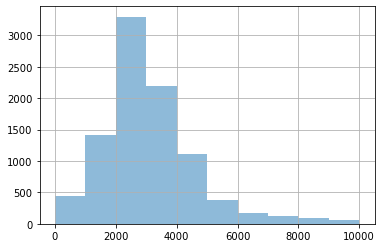

In [63]:
Toulouse_houses["Price_m2"].hist(bins=10, alpha=0.5)

OK That's looks good.

In [54]:
Nantes_houses["Price_m2"].describe()

count      7516.000000
mean       6914.668281
std       20832.578315
min           0.000100
25%        2437.784091
50%        3142.857143
75%        4101.266425
max      425000.000000
Name: Price_m2, dtype: float64

As for Toulouse, Prices per m2 superior to 10000 Eur are fake values as no one would pay for that for a single squared meter in Nantes !
Let's remove values above 10000 Eur/m2

In [55]:
Nantes_houses=Nantes_houses[Nantes_houses["Price_m2"] <= 10000]

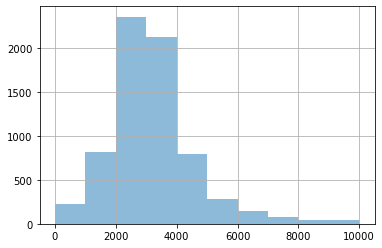

In [64]:
Nantes_houses["Price_m2"].hist(bins=10, alpha=0.5)

In [66]:
Bordeaux_houses["Price_m2"].describe()

count      6155.000000
mean      13716.407018
std       46623.811355
min           0.000659
25%        3652.603030
50%        4904.504505
75%        7812.500000
max      706666.666667
Name: Price_m2, dtype: float64

Bordeaux appears to be a more expensive city compared to the 2 other. 
This time, let's remove values above 20000 Eur/m2

In [67]:
Bordeaux_houses=Bordeaux_houses[Bordeaux_houses["Price_m2"] <= 20000]

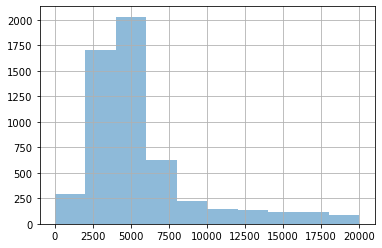

In [68]:
Bordeaux_houses["Price_m2"].hist(bins=10, alpha=0.5)

Median Price Calculation for each city

In [74]:
Toulouse_median = Toulouse_houses["Price_m2"].median()
Nantes_median = Nantes_houses["Price_m2"].median()
Bordeaux_median = Bordeaux_houses["Price_m2"].median()

print('Median Prices - Toulouse : ', Toulouse_median, ' - Nantes : ', Nantes_median, ' - Bordeaux : ', Bordeaux_median)

Median Prices - Toulouse :  2848.9795918367345  - Nantes :  3030.0  - Bordeaux :  4597.701149425287


Bordeaux, is by far more expensive than the 2 other cities. In order to perform homogeneous comparison between those cities, we need to classify houses prices in categories defined according to local median prices : Low, Medium Low, Medium, Medium High, High
Low <= 0.4 * Median / ML 0.4 to 0.8 * Median / Medium 0.85 to 1.2 / Medium High 1.2 to 1.8 / High above 1.8

In [77]:
Toulouse_houses["Houses_L"] = Toulouse_houses["Price_m2"] <= (0.4 * Toulouse_median)

In [81]:
Toulouse_houses.head()

,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Surface reelle bati,Price_m2,Houses_L
578935,111258.0,33.0,AV,MAURICE BOURGES-MAUNOURY,31200.0,TOULOUSE,79.0,1408.329114,False
578936,195000.0,9.0,RUE,DURAND,31200.0,TOULOUSE,58.0,3362.068966,False
578939,81276.0,33.0,AV,MAURICE BOURGES-MAUNOURY,31200.0,TOULOUSE,41.0,1982.341463,False
578941,80700.0,12.0,PL,ANDRE DASTE,31400.0,TOULOUSE,63.0,1280.952381,False
578942,299730.0,14.0,PORT,DE L EMBOUCHURE,31000.0,TOULOUSE,100.0,2997.300000,False


OK, works great. Note that in Paris Boroughs are identified by numbers. This number is linked to the post code (75001 => First Arrondissement)

### 1.1.4. Calling Foursquare

#### Define Foursquare Credentials and Version

In [107]:
CLIENT_ID = 'EKWBFB4AB23VDAGVOLH4MUBPDJOXLZOU4J1FGHBVTBCIDWPC' # your Foursquare ID
CLIENT_SECRET = 'LOMIFE0VX4FEGRIATERLSZCVALXP15P2QILULDWMMQKTRB4X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EKWBFB4AB23VDAGVOLH4MUBPDJOXLZOU4J1FGHBVTBCIDWPC
CLIENT_SECRET:LOMIFE0VX4FEGRIATERLSZCVALXP15P2QILULDWMMQKTRB4X


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [47]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [48]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [49]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=EKWBFB4AB23VDAGVOLH4MUBPDJOXLZOU4J1FGHBVTBCIDWPC&client_secret=LOMIFE0VX4FEGRIATERLSZCVALXP15P2QILULDWMMQKTRB4X&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [50]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d91ddf1342adf0030768640'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [51]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        json_normalize
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [52]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Dunkin',Donut Shop,40.877136,-73.906666


And how many venues were returned by Foursquare?

In [53]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [55]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [56]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3327, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood

In [57]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,45,45,45,45,45,45
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [58]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 340 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [59]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaur

And let's examine the new dataframe size.

In [60]:
manhattan_onehot.shape

(3327, 341)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaur

#### Let's confirm the new size

In [62]:
manhattan_grouped.shape

(40, 341)

#### Let's print each neighborhood along with the top 5 most common venues

In [63]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1    Coffee Shop  0.07
2          Hotel  0.05
3            Gym  0.04
4  Memorial Site  0.04


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.06
1     Pizza Place  0.06
2            Café  0.04
3  Cosmetics Shop  0.04
4   Grocery Store  0.03


----Central Harlem----
                  venue  freq
0    African Restaurant  0.07
1  Gym / Fitness Center  0.04
2    Chinese Restaurant  0.04
3            Public Art  0.04
4   American Restaurant  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1      Ice Cream Shop  0.05
2  Italian Restaurant  0.05
3              Bakery  0.05
4           Nightclub  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.08
1           Cocktail Bar  0.05
2    American Restaurant  0.04
3                 Bakery  0.04
4  Vietnamese Restaurant  0.04


----Civic Center----
                  venue  freq
0  Gym / Fitness C

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [ ]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Finally, let's visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

#### Cluster 2

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

#### Cluster 3

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

#### Cluster 4

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

#### Cluster 5

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).